### Importing Modules

In [1]:
pip install d2l # Note: If prompted to restart, please do so and run the proceeding cells.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    U

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
import zipfile
from tqdm import tqdm
import os
warnings.filterwarnings('ignore')

from torch import nn
from d2l import torch as d2l

### Creating the Toon Dataset

In [2]:
# Downloading dataset
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.34G/2.34G [02:23<00:00, 21.4MB/s]
100% 2.34G/2.34G [02:23<00:00, 17.5MB/s]


In [3]:
# Extracting the data
filename = '/content/cartoon-faces-googles-cartoon-set.zip' # Note that filename might be different depending on the device, this one should work for google colab.
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('../content/')

In [4]:
# Creating the DataLoader after making the transformations.

# Toon data Transformations
data_transforms = transforms.Compose([transforms.Resize((128, 128)), # Note: Due to limited resources and time constraints, I chose a 64*G4 transformation but higher ones can be applied for better results.
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])

# Toon Dataset and DataLoader
batch_size = 1024 # Chose 1024 because of computational limitations, however greater batch sizes have shown better results in my experience.
toon_dataset = datasets.ImageFolder(root='../content/cartoonset100k_jpg/',
                                  transform=data_transforms,
                                  target_transform=None) # Transforms for labels, not applicable here.
toon_dataloader = DataLoader(dataset=toon_dataset,
                          shuffle=True,
                          num_workers=os.cpu_count(), # Setting numworkers to what is available.
                          batch_size=batch_size)

### Visualizing the Google Toon Image Data

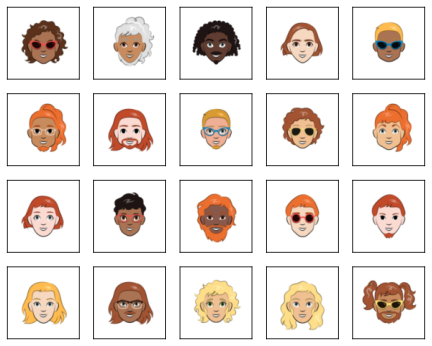

In [ ]:
# Here we are taking one batch(defined above) and visualizing its first 20 items.
d2l.set_figsize((4, 4))
for X, y in toon_dataloader:
  imgs = X[0:20, :, :, :].permute(0, 2, 3, 1)/2+0.5
  d2l.show_images(imgs, num_rows=4, num_cols=5)
  break

### The Generator

This generator will make up half of our GAN model. It will be responsible for creating the fake images that we want as the final output from this project. We will start by creating generator units(G_Unit), and use those to create the overall generator architecture(G_arch).

In [7]:
# Creating the generator class
class G_arch_instance(nn.Module):
  def __init__(self, in_channels, out_channels,  kernel_size=4, stride=2,
                 padding=1, **kwargs):
    super(G_arch_instance, self).__init__(**kwargs)

    # The first layer takes a tensor of 100 channels(initialized during training) and outputs
    # 2048 channels(64*32 decreased from 64*64 because of computational limitations). The second to sixth layer
    # mostly decrease the output channels gradually for optimal learning. These, along with the initial output
    # could be increased(more neurons) for better and more detail oriented learning.

    self.gen = nn.Sequential( # Using nn.Sequential for readability.
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=2048, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(2048),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=2048, out_channels=2048, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(2048),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.Tanh()
        )

  def forward(self, inp):
    return self.gen(inp)

G_arch = G_arch_instance(in_channels=100, out_channels=3)

In [8]:
# Testing generator output shape. Should output 128x128 images.
batch_size = 64
dummy_input_Generator = torch.randn(batch_size, 100, 1, 1)
output_generator = G_arch(dummy_input_Generator)
print(f'Expected outcome shape: shape torch.Size([{batch_size}, 3, 128, 128])')
print(f"Actual outcome shape: {output_generator.shape}")

Expected outcome shape: shape torch.Size([64, 3, 128, 128])
Actual outcome shape: torch.Size([64, 3, 128, 128])


### The Discriminator

The other half of our GAN model, the discriminator, takes the output from the generator, and tells us if it is real or fake. Feedback from the discriminator over time makes the generator better at creating fake images from random noise that look real. Here, like in the case of the generator, we will start by creating discriminator units(D_Unit), and use those to create the overall discriminator architecture(D_arch).

In [9]:
# Constructing the Discriminator class.
class D_arch_instance(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, kernel_size=4, stride=2,
               slope=0.2, padding=1, **kwargs):
    super(D_arch_instance, self).__init__(**kwargs)
    self.disc = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=64*2, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(64*2),
        nn.LeakyReLU(slope),

        nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(64*4),
        nn.LeakyReLU(slope),

        nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(64*8),
        nn.LeakyReLU(slope),

        nn.Conv2d(in_channels=64*8, out_channels=64*16, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(64*16),
        nn.LeakyReLU(slope),

        nn.Conv2d(in_channels=64*16, out_channels=64*32, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(64*32),
        nn.LeakyReLU(slope),

        nn.Conv2d(in_channels=64*32, out_channels=out_channels, kernel_size=4, stride=1, padding=0)
        )

  def forward(self, X):
    return self.disc(X)

D_arch = D_arch_instance()

In [10]:
# Testing discriminator output shape. Should output a binary.
batch_size = 64
output_discriminator = D_arch(output_generator)
print(f'Expected outcome shape: shape torch.Size([{batch_size}, 1, 1, 1]')
print(f"Actual outcome shape: {output_discriminator.shape}")

Expected outcome shape: shape torch.Size([64, 1, 1, 1]
Actual outcome shape: torch.Size([64, 1, 1, 1])


### Cartoon GAN Training

Here we will define a function to train our GAN model, the protocol outlined by AstonZhang, ZacharyC.Lipton, MuLi, and AlexanderJ.Smola in [Dive into Deep Learning](https://classic.d2l.ai/d2l-en-pytorch.pdf) was used as inspiration for our GAN training.

In [ ]:
def train(D_arch, G_arch, toon_dataloader, num_epochs, lr, # The usual parameters that we will need for training.
          initial_dim, device=d2l.try_gpu()):              # Here the initial_dim will be our initial input into the generator and device will ideally be set to gpu for efficient processing.

    # Moving the architectures to the preferred device.
    D_arch, G_arch = D_arch.to(device), G_arch.to(device)

    # Defining the keyword arguments for the models.
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}

    # Defining the loss function
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    # Defining the optimizers
    trainer_D = torch.optim.Adam(D_arch.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(G_arch.parameters(), **trainer_hp)

    # Initializing the parameters of both the discriminator and the generator using a normal distribution.
    for w in D_arch.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in G_arch.parameters():
        nn.init.normal_(w, 0, 0.02)


    # Creating the animation that will track the loss of the generator and the discriminator over time.
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    # Making the training loop, going over a set number of epochs.
    for epoch in tqdm(range(1, num_epochs + 1)):
        # Setting the timer and metrics for d2l module usage.
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, examples

        # Going over each batch one by one.
        for X, _ in toon_dataloader:
            batch_size = X.shape[0] # First dim of the batch is the batch size.
            Z = torch.normal(0, 1, size=(batch_size, initial_dim, 1, 1))
            X, Z = X.to(device), Z.to(device) # Moving image data to the same device the the models are in.
            # Updating loss_D, loss_G, examples
            metric.add(d2l.update_D(X, Z, D_arch, G_arch, loss, trainer_D),
                       d2l.update_G(Z, D_arch, G_arch, loss, trainer_G),
                       batch_size)

        # Making the initial generator input and normalizing it to showcase output examples.
        Z = torch.normal(0, 1, size=(21, initial_dim, 1, 1), device=device)

        # Creating the fake images and displaying them.
        fake_x = G_arch(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat([
            torch.cat([fake_x[i * 7 + j].cpu().detach()
                       for j in range(7)], dim=1)
            for i in range(len(fake_x) // 7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)

        # Showing the generator and discriminator losses among other information.
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

100%|██████████| 110/110 [3:16:41<00:00, 107.28s/it]


loss_D 0.173, loss_G 7.300, 931.4 examples/sec on cuda:0


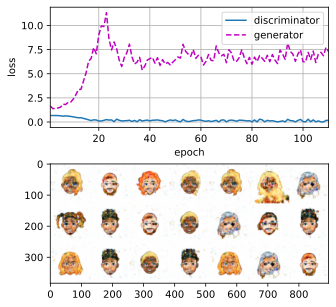

In [ ]:
# Train the network on GPU
# See how the loss of D and G change over time, and how the final image generations look like.
initial_dim, lr, num_epochs = 100, 0.005, 110
train(D_arch, G_arch, toon_dataloader, num_epochs, lr, initial_dim)

In [ ]:
# Saving the state dictionaries to the current runtime.
torch.save(G_arch.state_dict(), 'G_arch.pth')
torch.save(D_arch.state_dict(), 'D_arch.pth')

After the generator state dict is saved, it could be used in the loading_toons.ipynb file to showcase outputs.

### Appendix

The proceeding cells showcase a more pythonic way of creating the generator and discriminator as outlined by AstonZhang, ZacharyC.Lipton, MuLi, and AlexanderJ.Smola in [Dive into Deep Learning](https://www.google.com/url?q=https%3A%2F%2Fclassic.d2l.ai%2Fd2l-en-pytorch.pdf). I chose to create my own class to keep the code more understandable.

### The Alternative Generator

In [ ]:
class G_Unit(nn.Module):
    def __init__(self, in_channels, out_channels,  kernel_size=4, stride=2,
                 padding=1, **kwargs): # **kwargs implemented here because additional arguments(lr and betas) will be added during training.
        super(G_Unit, self).__init__(**kwargs)
        # Creating the generator unit. Using nn.Sequential for readability.
        self.unit = nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                                nn.BatchNorm2d(out_channels), # Using batch normalization for better results.
                                nn.ReLU()
                                )

    def forward(self, X):
        output = self.unit(X)
        return output

In [ ]:
G_arch = nn.Sequential( # Using nn.Sequential for readability.
    G_Unit(in_channels=100, out_channels=2048),      # The first layer takes a tensor of 100 channels(initialized during training) and outputs
    G_Unit(in_channels=1024*2, out_channels=1024*2), # 2048 channels(64*32 decreased from 64*64 because of computational limitations). The second to sixth layer
    G_Unit(in_channels=1024*2, out_channels=1024),   # mostly decrease the output channels gradually for optimal learning. These, along with the initial output
    G_Unit(in_channels=1024, out_channels=512),      # could be increased(more neurons) for better and more detail oriented learning.
    G_Unit(in_channels=512, out_channels=256),
    G_Unit(in_channels=256, out_channels=128),

    nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
    nn.Tanh() # Tanh limits the range from -1 to 1, ideal for image related data.
    )

### The Alternative Discriminator

In [ ]:
class D_Unit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_Unit, self).__init__(**kwargs)
        self.unit = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(alpha)
                                )

    def forward(self, X):
      output = self.unit(X)
      return output

In [ ]:
D_arch = nn.Sequential(
    D_Unit(in_channels=3, out_channels=64*2),
    D_Unit(in_channels=64*2, out_channels=64*4),
    D_Unit(in_channels=64*4, out_channels=64*8),
    D_Unit(in_channels=64*8, out_channels=64*16),
    D_Unit(in_channels=64*16, out_channels=64*32),
    nn.Conv2d(64*32, 1, 4, 1, 0)
    )

Todo list:
- Proofread and debug.
- Make the training code more readable.
- Add to the evaluative output.
- Try training with a higher number of epochs(1000 maybe).